In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import yaml
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [2]:
# load yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    DATA_PATH = config.get("data_path")
    if DATA_PATH is None:
        print("ERROR: No data path provided")
    USE_DRIVE = bool(config.get("use_drive", False))

In [3]:
# load from drive if requested
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
team_statistics_df = pd.read_csv(os.path.join(DATA_PATH, "team_statistics_v2.csv"))
team_statistics_df.head()

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,opponentTeamId,opponentTeamCity,opponentTeamName,opponentTeamTricode,...,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,teamScore,plusMinusPoints,opponentScore,win
0,29601184,1610612739,Cleveland,Cavaliers,CLE,cavaliers,1610612764,Washington,Bullets,WAS,...,36,22,8,6,8,20,81,-4.0,85.0,0
1,29601184,1610612764,Washington,Bullets,WAS,bullets,1610612739,Cleveland,Cavaliers,CLE,...,46,18,3,5,11,22,85,4.0,81.0,1
2,29601185,1610612754,Indiana,Pacers,IND,pacers,1610612765,Detroit,Pistons,DET,...,55,27,7,3,14,30,120,-4.0,124.0,0
3,29601185,1610612765,Detroit,Pistons,DET,pistons,1610612754,Indiana,Pacers,IND,...,37,19,6,4,12,25,124,4.0,120.0,1
4,29601187,1610612759,San Antonio,Spurs,SAS,spurs,1610612745,Houston,Rockets,HOU,...,46,21,5,5,8,21,99,-4.0,103.0,0


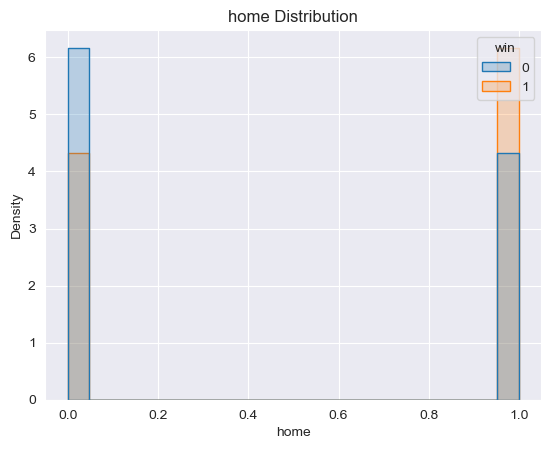

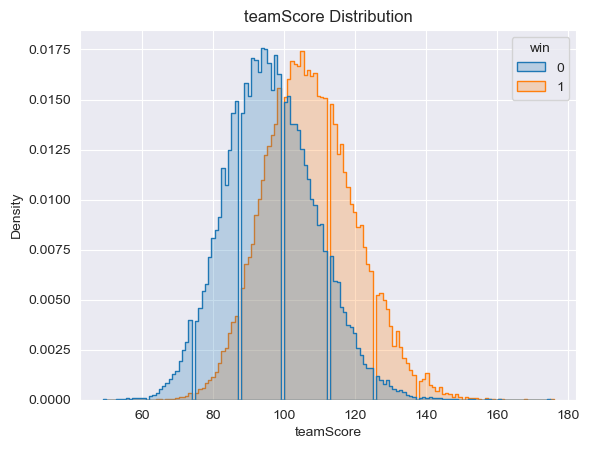

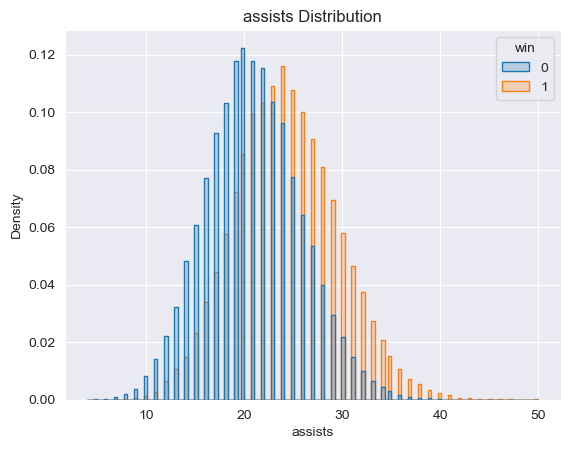

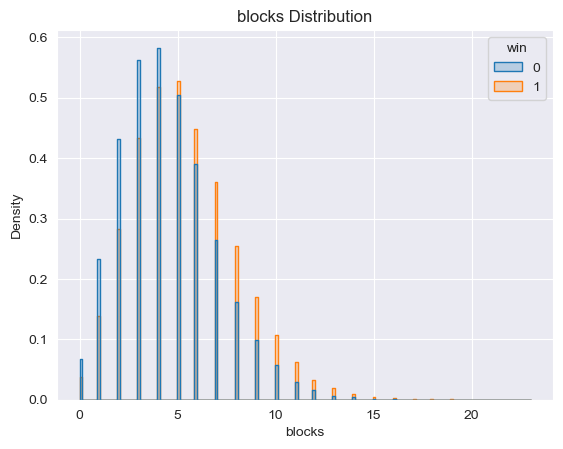

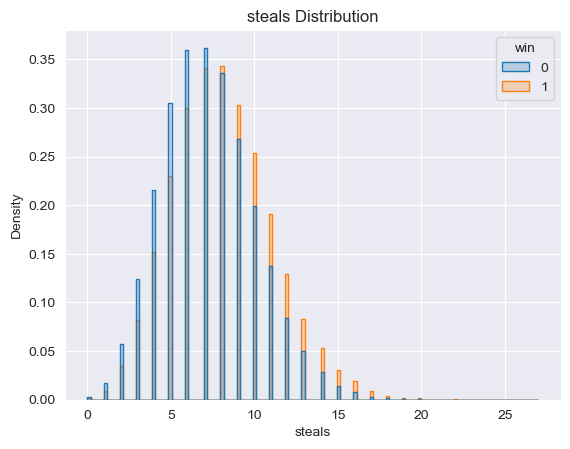

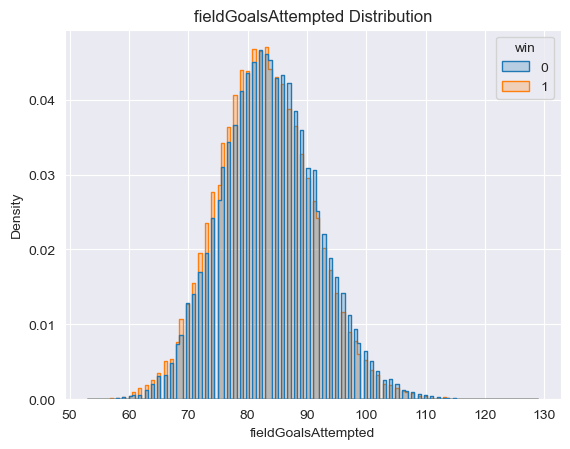

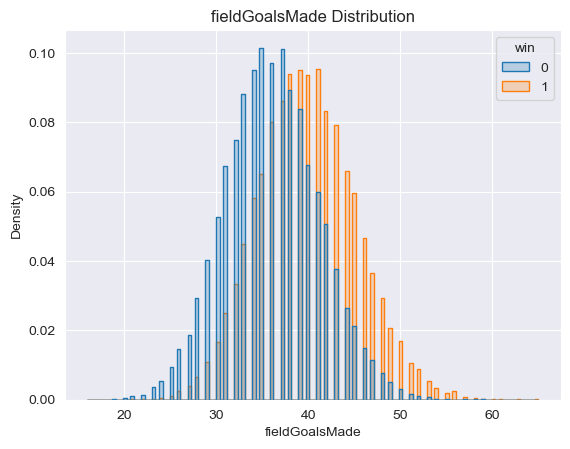

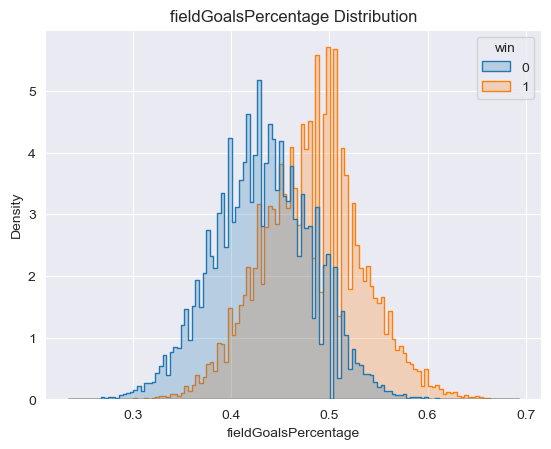

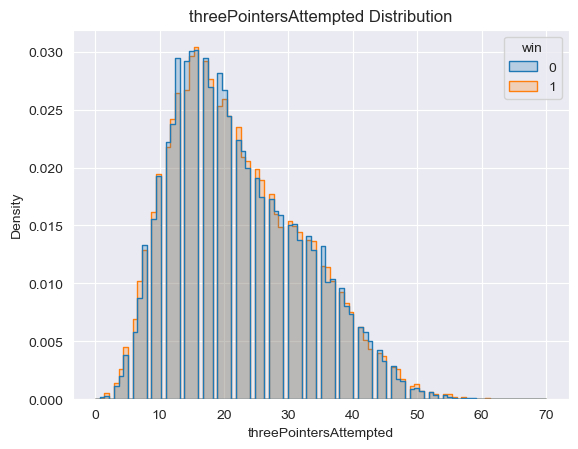

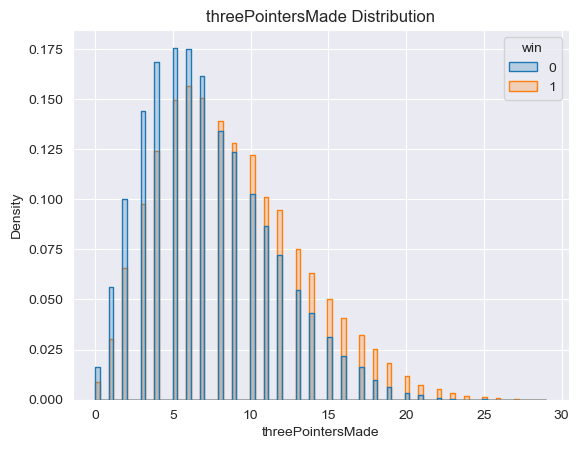

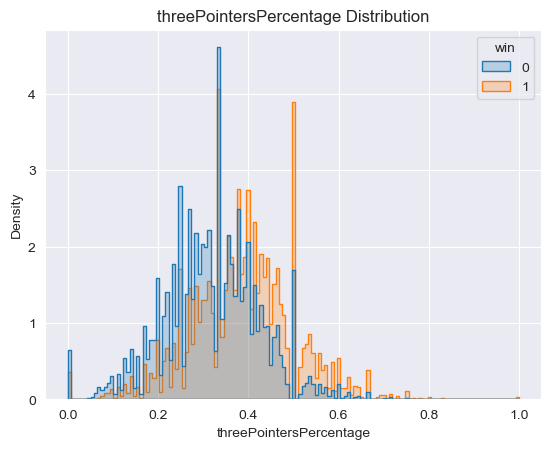

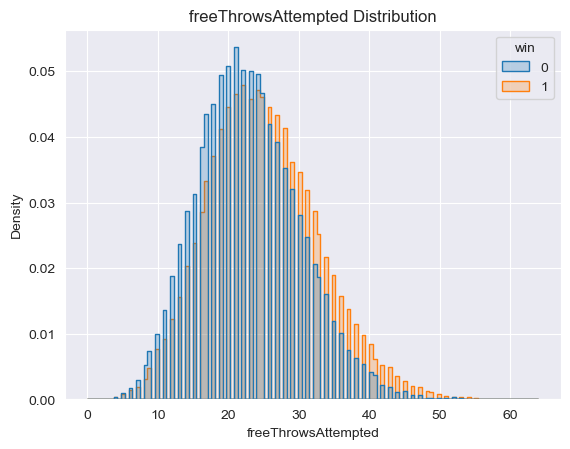

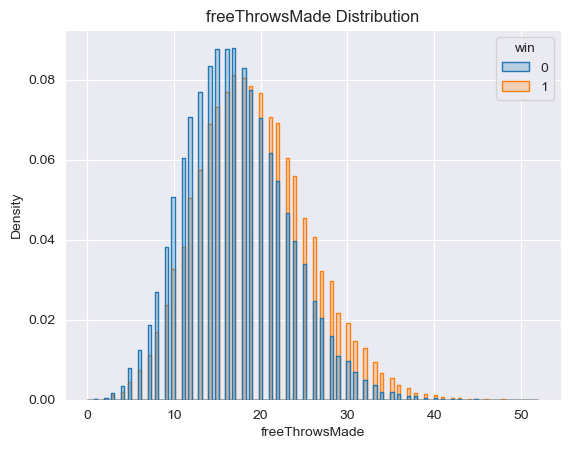

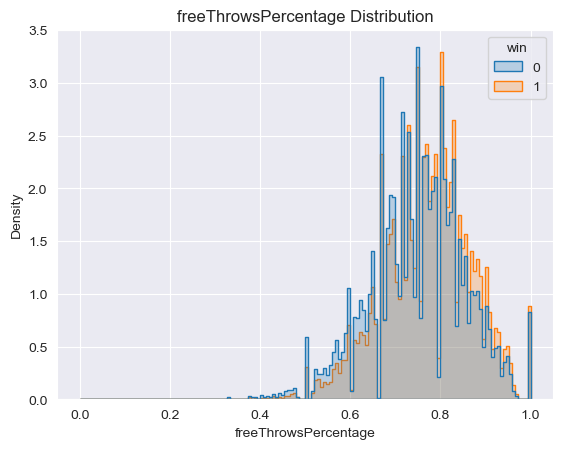

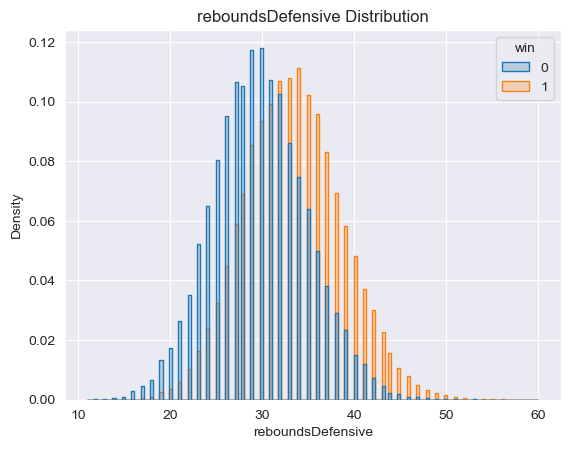

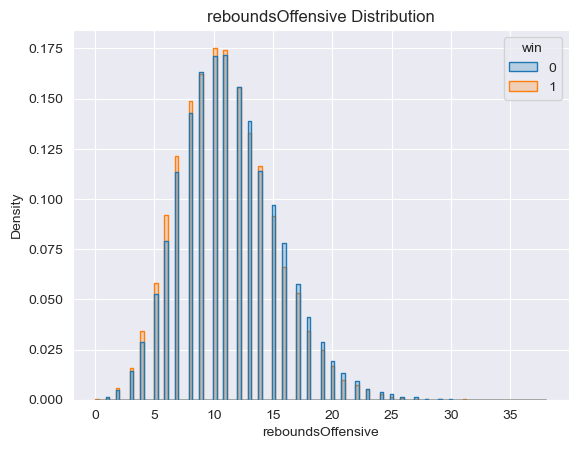

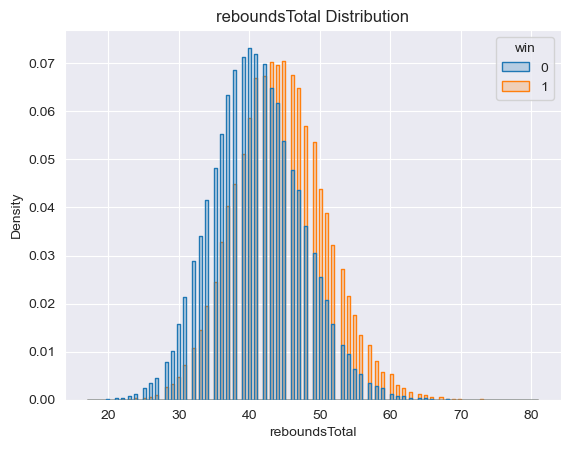

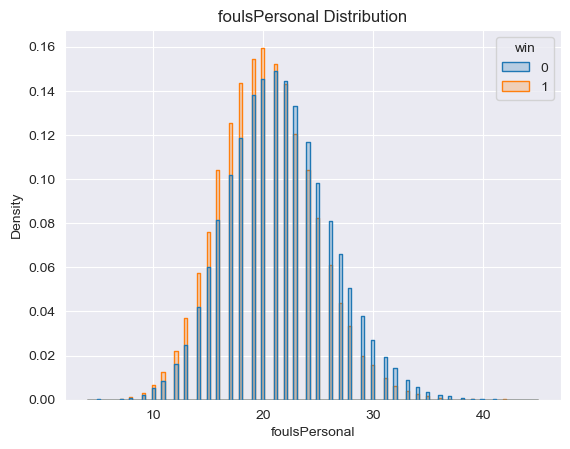

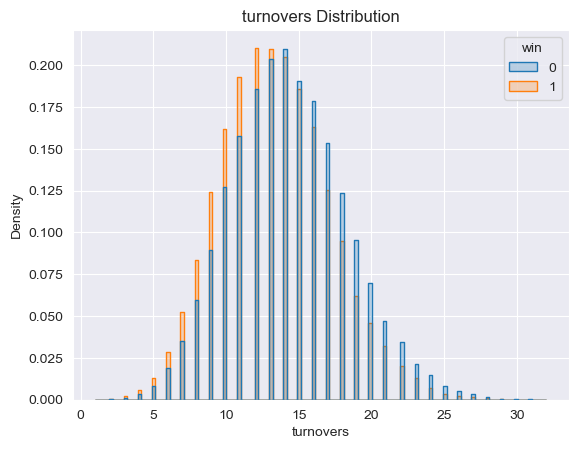

In [5]:
cols = ["home", "teamScore", "assists", "blocks", "steals", "fieldGoalsAttempted", "fieldGoalsMade", "fieldGoalsPercentage", "threePointersAttempted", "threePointersMade", "threePointersPercentage", "freeThrowsAttempted", "freeThrowsMade", "freeThrowsPercentage", "reboundsDefensive", "reboundsOffensive", "reboundsTotal", "foulsPersonal", "turnovers"]

for i, col in enumerate(cols):
    sns.histplot(data=team_statistics_df, x=col, hue='win', element='step', stat='density')
    #sns.histplot(team_statistics_df[col], ax=axs[i])
    plt.title(f"{col} Distribution")
    plt.show()



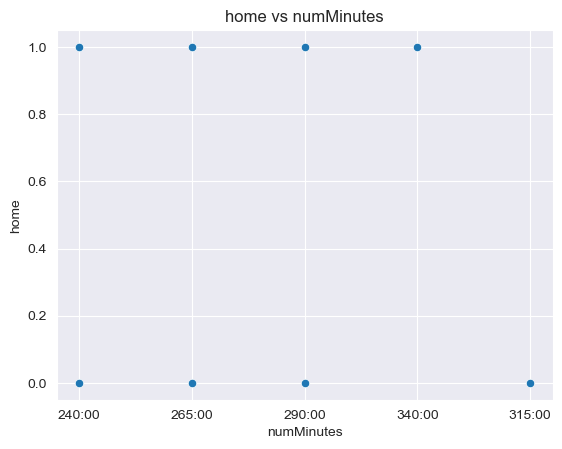

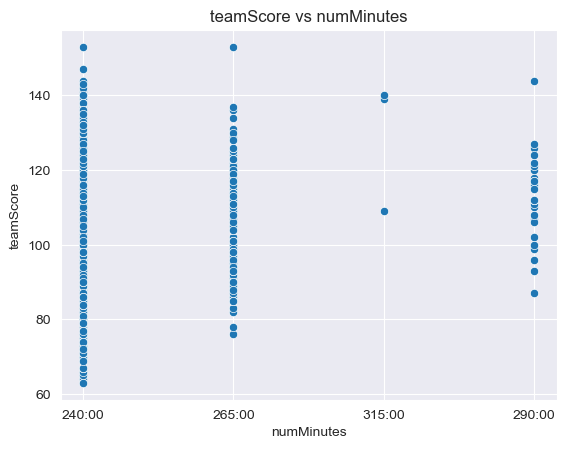

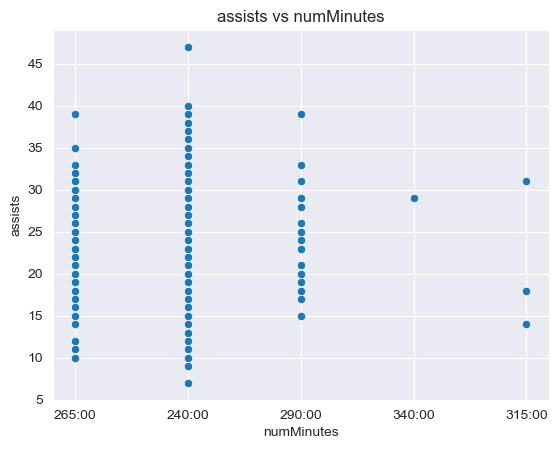

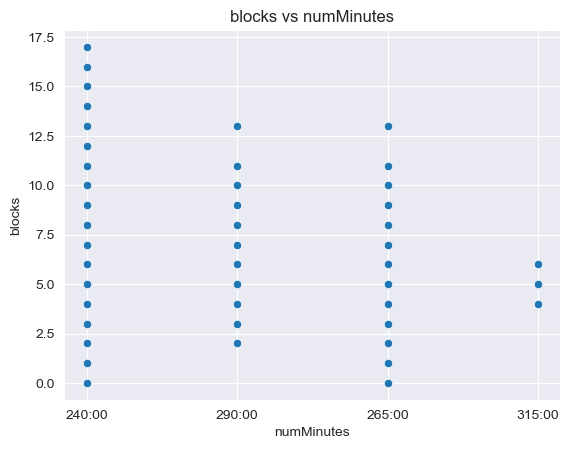

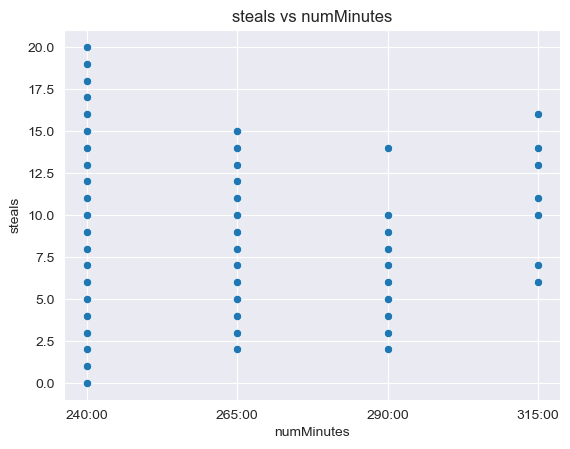

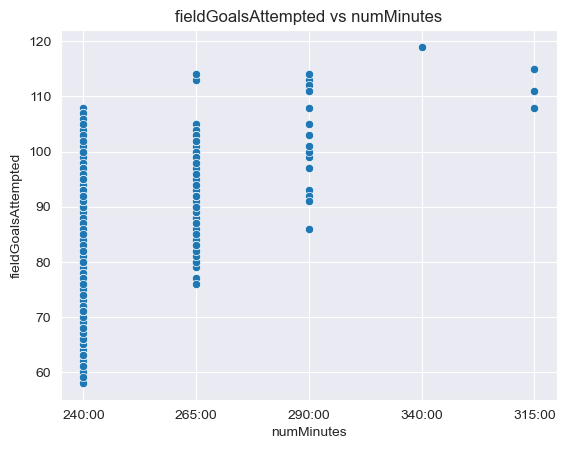

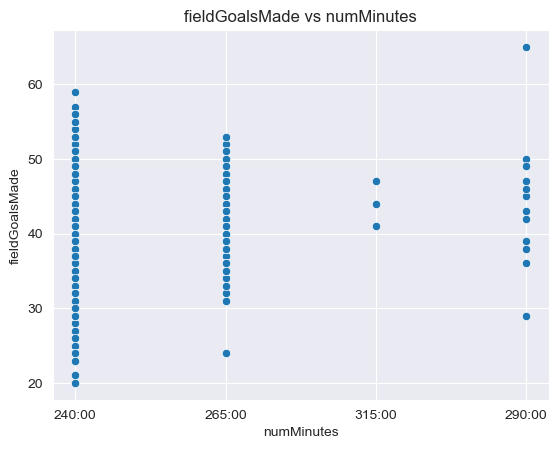

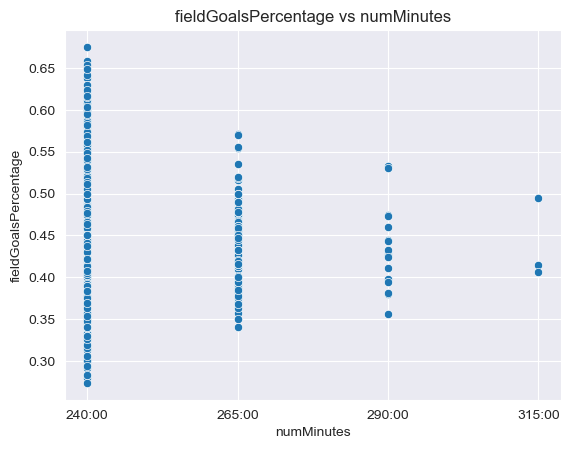

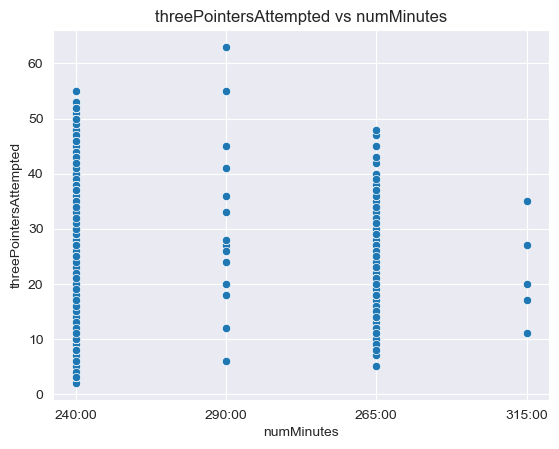

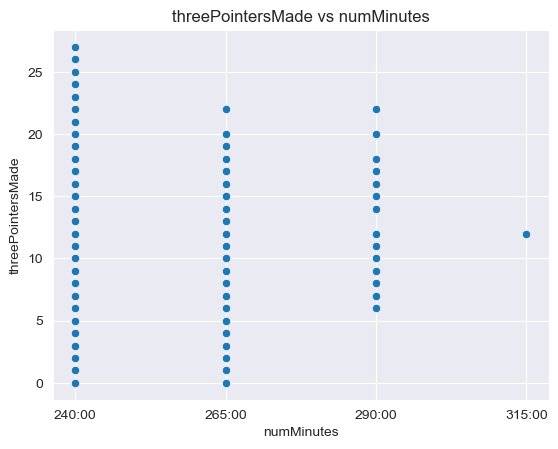

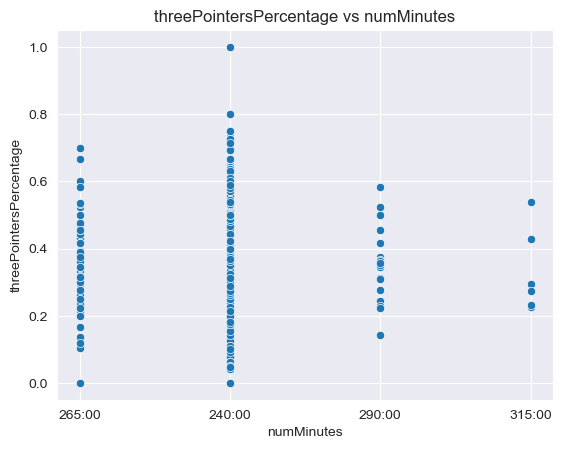

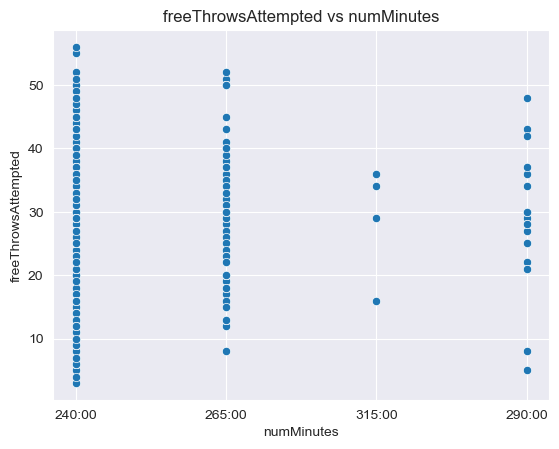

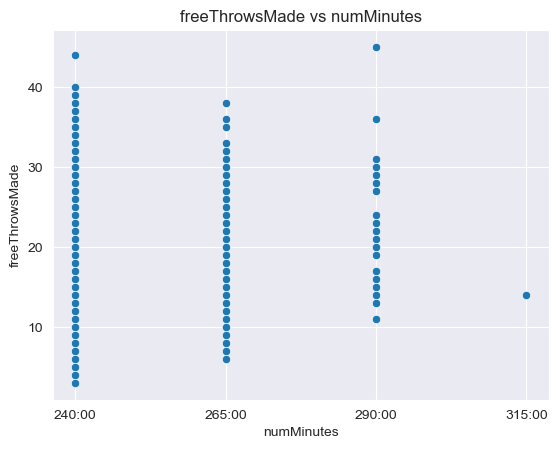

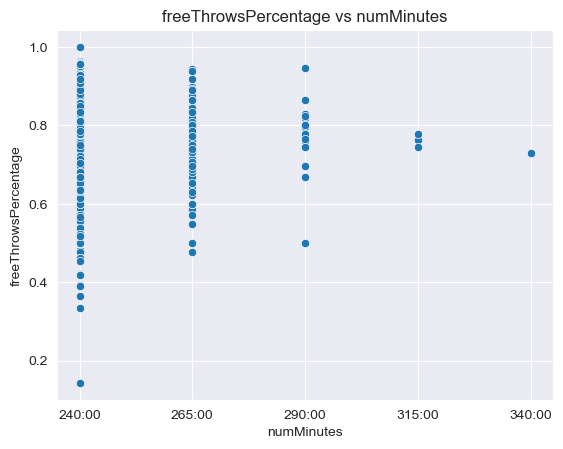

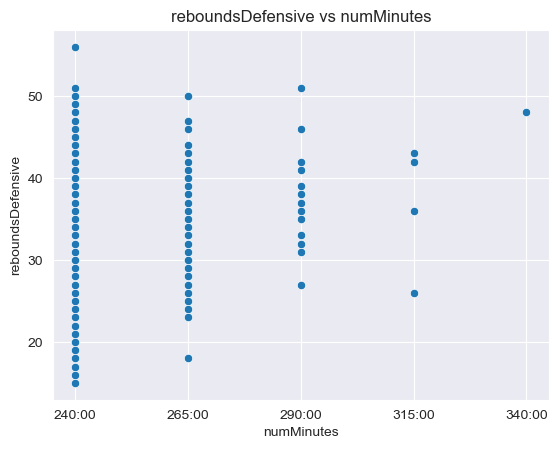

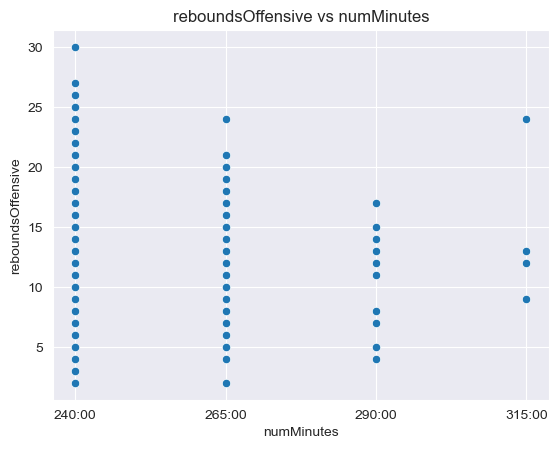

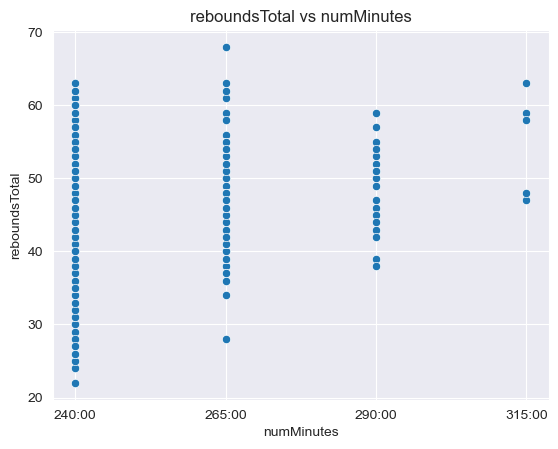

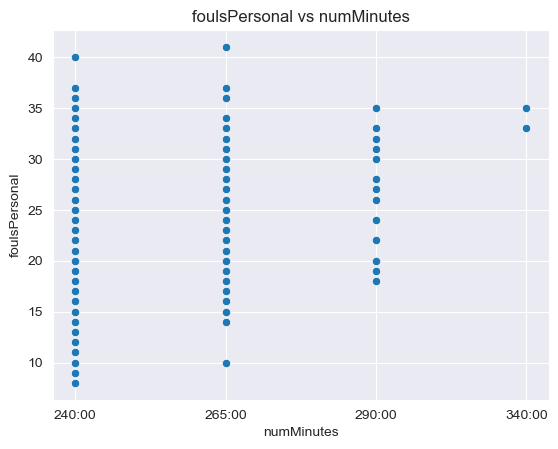

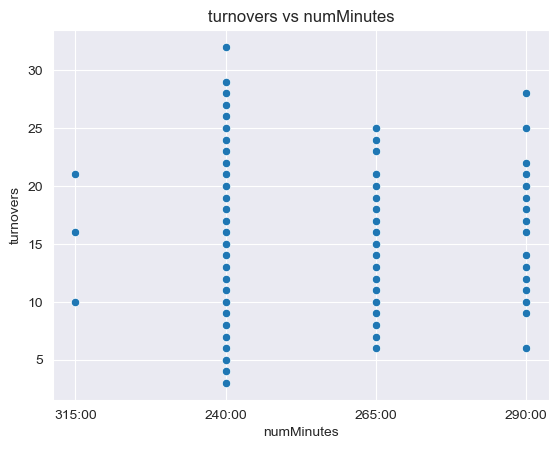

In [6]:
for col in cols:
    sns.scatterplot(x='numMinutes', y=col, data=team_statistics_df.sample(3000))
    plt.title(f'{col} vs numMinutes')
    plt.show()

Since we are dealing with countable variables, such as assists, rebounds, steals etc., if we want to show whether a winning team has more "skill" in this variable than the other, we have to account for the fact that if a team simply has more chances to score, it will have more assists, rebounds, steals etc. even though they are not better at these skills than the other team. This can be seen by the plots above showing that, by playing more minutes in a game (Overtime games for example), the trend seems to go higher for these countable variables, and the same will therefore be true if we can pack more attempts within the same minutes. So, we have to adjust the variables by the amount of possessions a team is playing at.

Conventionally, a possession is defined as a play that ends either in a turnover, a field goal, or a free throw (foul). Additionally, possessions are extended when the team gets an offensive rebound. The formula for possessions is therefore:
$$Possessions = FGA + (0.44 * FTA) + TO - OREB$$
Source: https://support.fastmodelsports.com/support/solutions/articles/9000231009-how-do-we-estimate-pace-and-possessions-

In [7]:
team_statistics_df["possessions"] = team_statistics_df["fieldGoalsAttempted"] + (0.44 * team_statistics_df["freeThrowsAttempted"]) + team_statistics_df["turnovers"] - team_statistics_df["reboundsOffensive"]

With the possessions, we can then normalize the countable variables by the amount of possessions a team is playing at.

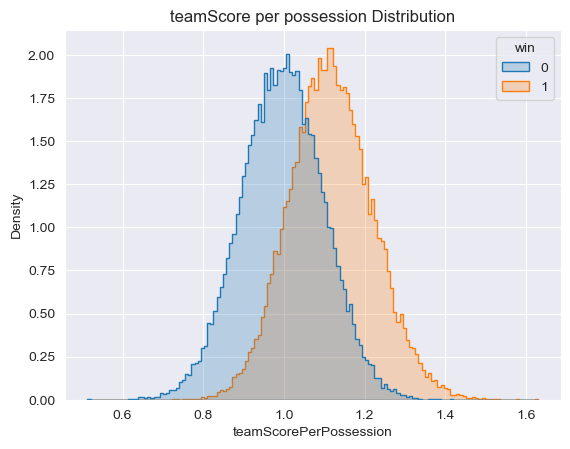

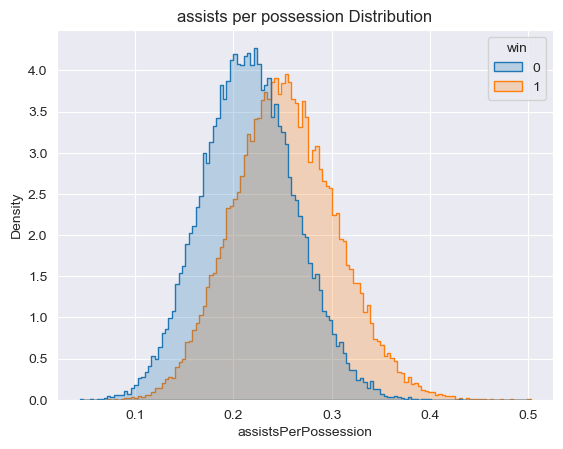

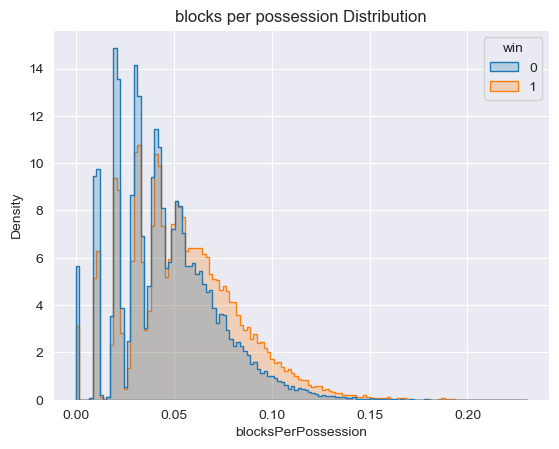

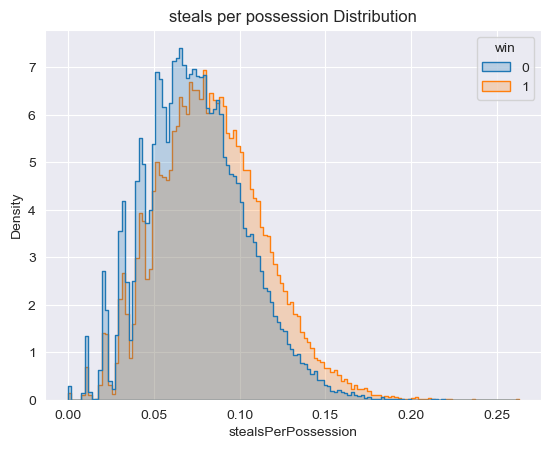

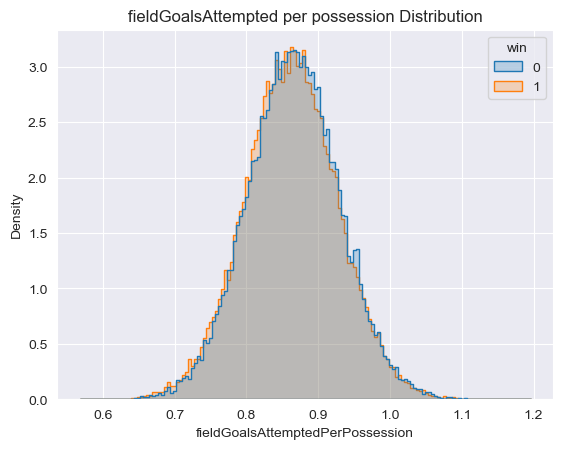

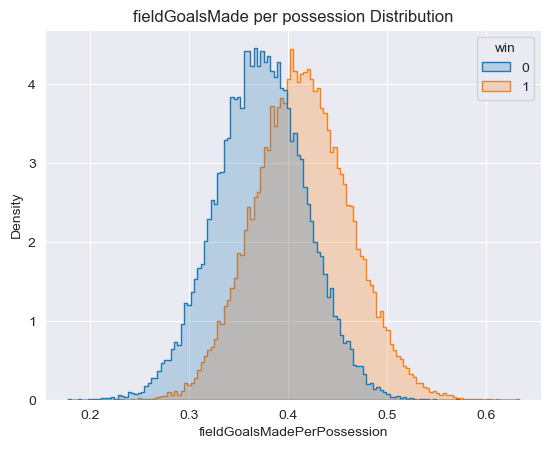

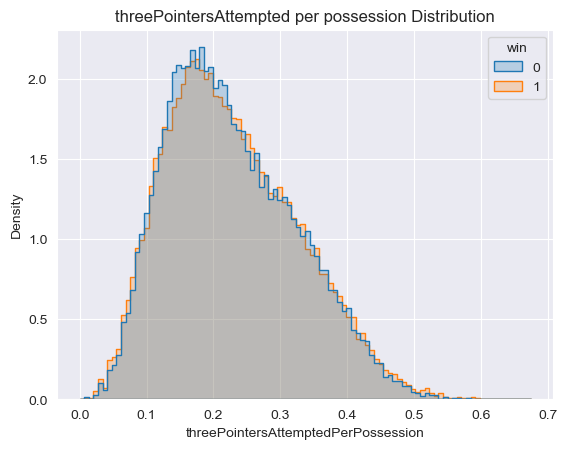

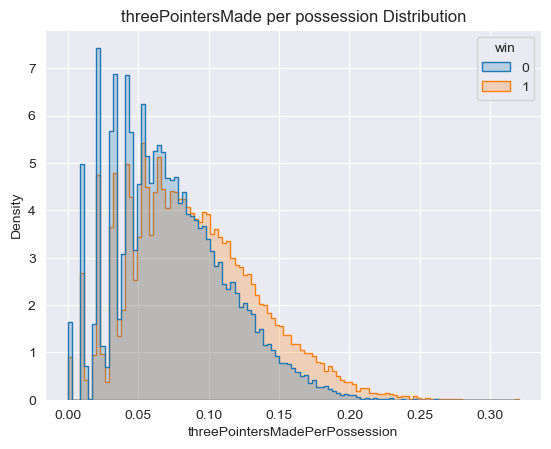

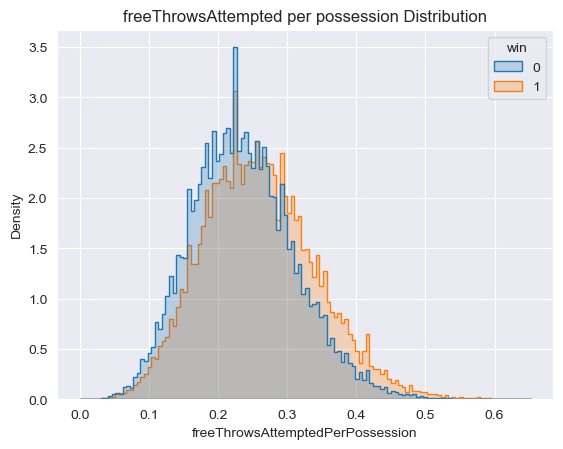

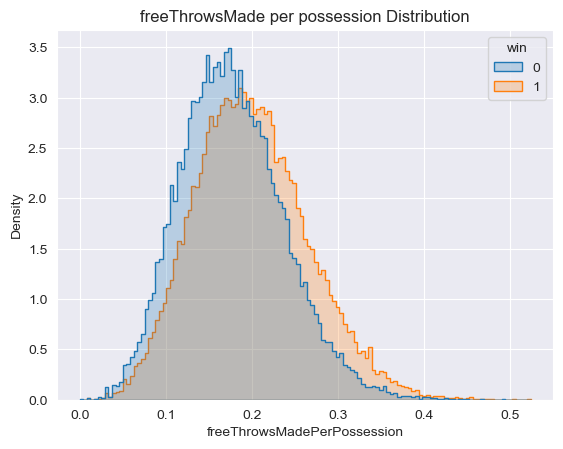

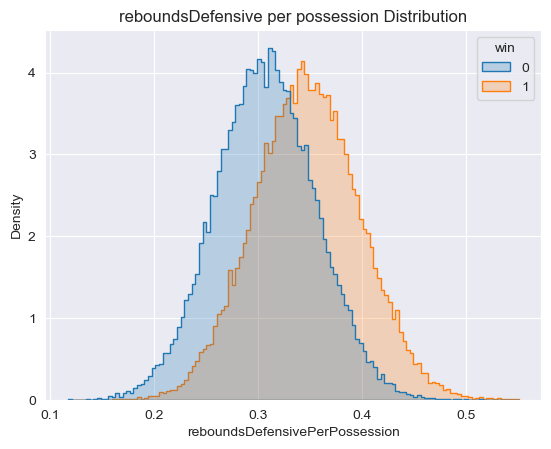

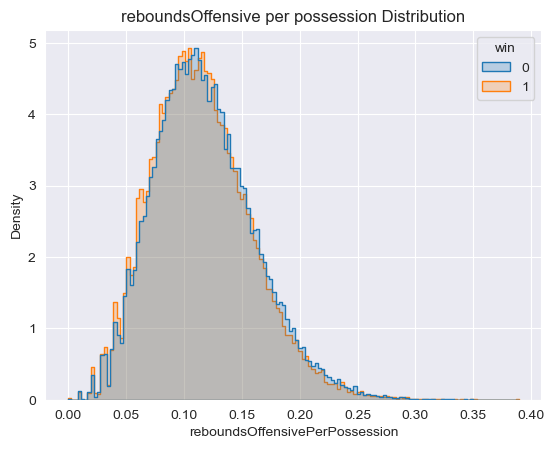

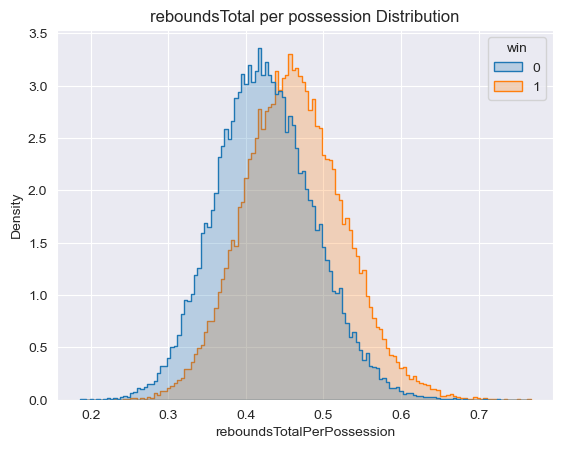

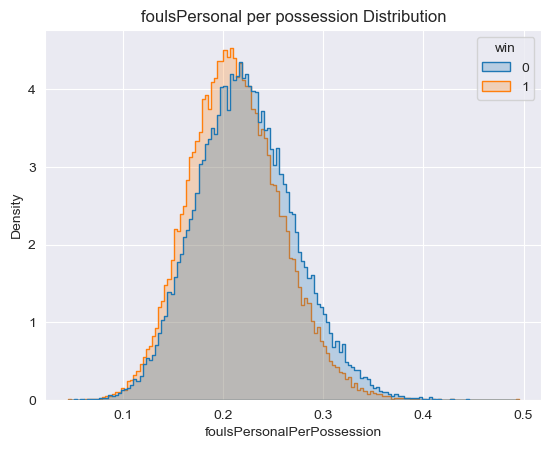

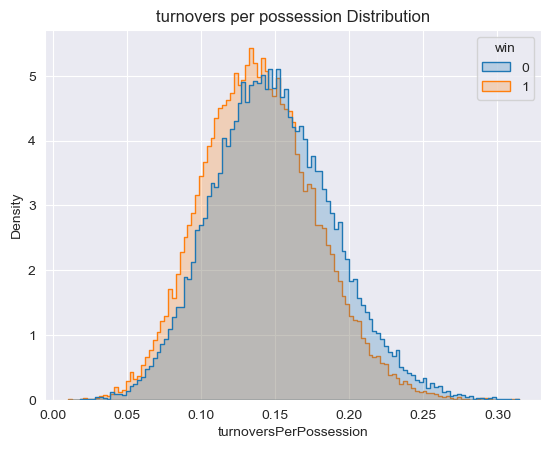

In [8]:
per_possession_cols = ["teamScore", "assists", "blocks", "steals",
                 "fieldGoalsAttempted", "fieldGoalsMade",
                 "threePointersAttempted", "threePointersMade",
                 "freeThrowsAttempted", "freeThrowsMade",
                 "reboundsDefensive", "reboundsOffensive",
                 "reboundsTotal", "foulsPersonal", "turnovers"]

for col in per_possession_cols:
    team_statistics_df[col + "PerPossession"] = team_statistics_df[col] / team_statistics_df["possessions"]
    sns.histplot(data=team_statistics_df, x=col + "PerPossession", hue='win', element='step', stat='density')
    plt.title(f"{col} per possession Distribution")
    plt.show()

We also calcualted the following metrics:

$$
\text{eFG\%} = \frac{\text{FGM} + 0.5 \times \text{3PM}}{\text{FGA}}
$$
Effective FG%: To give more weight to 3-pointers, as they give more points than 2 pointers obviously

$$
TS\% = \frac{PTS}{2 \times \left(FGA + 0.44 \cdot FTA\right)}
$$
True Shooting %: A metric that combines 2-pointers, 3-pointers and free-throws

$$
\text{Points per Shot Attempt} = \frac{PTS}{FGA}
$$
Points Per Shot Attempt (PPS): Simple shot efficiency metric

$$
FTR = \frac{FTA}{FGA}
$$
Free Throw Rate: How often you get fouled relative to shooting.

$$
\text{Assist Rate} = \frac{AST}{\text{Possessions}}
$$
Self explanatory

$$
\text{Turnover Rate} = \frac{TOV}{\text{Possessions}}
$$
Self explanatory

$$
\text{Assist to Turnover Ratio} = \frac{AST}{TOV}
$$
Self explanatory


In [9]:
# Calculate all metrics above:
team_statistics_df['effectiveFieldGoalPercentage'] = team_statistics_df['fieldGoalsMade'] + 0.5 * team_statistics_df['threePointersAttempted'] / team_statistics_df['fieldGoalsAttempted']
team_statistics_df['trueShootingPercentage'] = team_statistics_df['teamScore'] / (2 * (team_statistics_df['fieldGoalsAttempted'] + 0.44 * team_statistics_df['freeThrowsAttempted']))
team_statistics_df['pointsPerShotAttempt'] = team_statistics_df['teamScore'] / team_statistics_df['fieldGoalsAttempted']
team_statistics_df['freeThrowRate'] = team_statistics_df['freeThrowsAttempted'] / team_statistics_df['fieldGoalsMade']
team_statistics_df['assistRate'] = team_statistics_df['assists'] / team_statistics_df['possessions']
team_statistics_df['turnoverRate'] = team_statistics_df['turnovers'] / team_statistics_df['possessions']
team_statistics_df['assistToTurnover'] = team_statistics_df['assists'] / team_statistics_df['turnovers']

In [10]:
# Save the dataframe to a csv file
team_statistics_df.to_csv(os.path.join(DATA_PATH, "team_statistics_advanced.csv"), index=False)

We can now move on to testing:

In [11]:
win = team_statistics_df[team_statistics_df["win"] == 1]
loss = team_statistics_df[team_statistics_df["win"] == 0]
paired = pd.merge(win, loss, on=["gameId"], suffixes=("_win", "_loss"))

In [12]:
cols = [c for c in team_statistics_df.columns if c.endswith("PerPossession") or c.endswith("Percentage")]
cols_additional = ["pointsPerShotAttempt", "freeThrowRate", "assistRate", "turnoverRate", "assistToTurnover"]
cols = cols + cols_additional


differences = paired[[f"{col}_win" for col in cols]].values - paired[[f"{col}_loss" for col in cols]].values
differences = pd.DataFrame(differences, columns=cols)

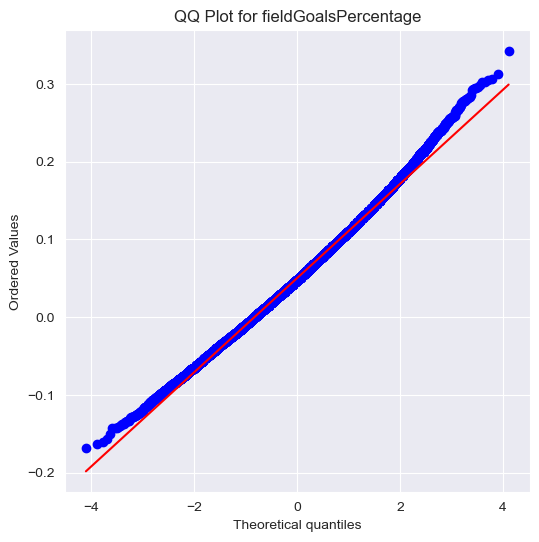

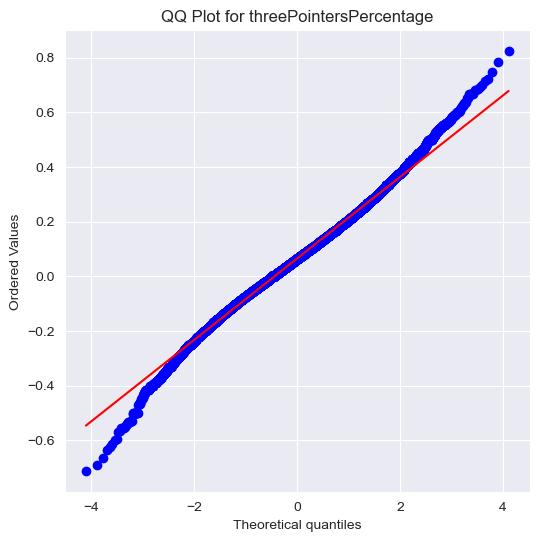

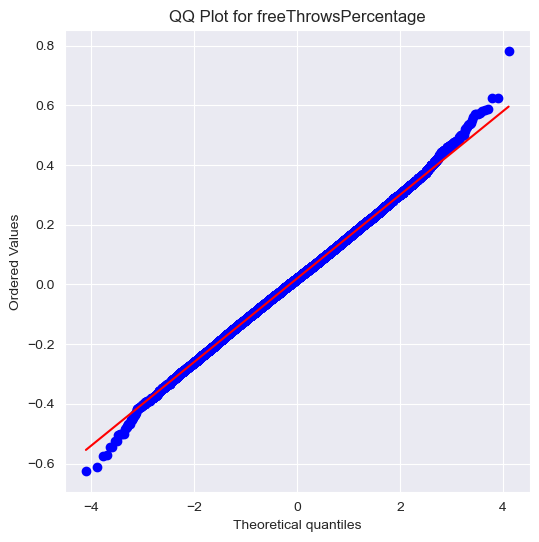

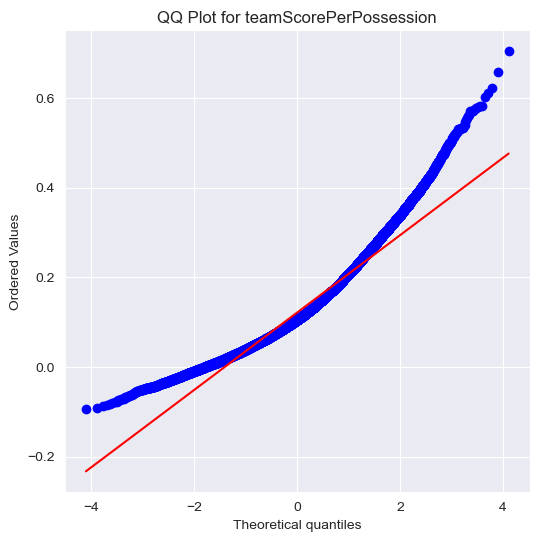

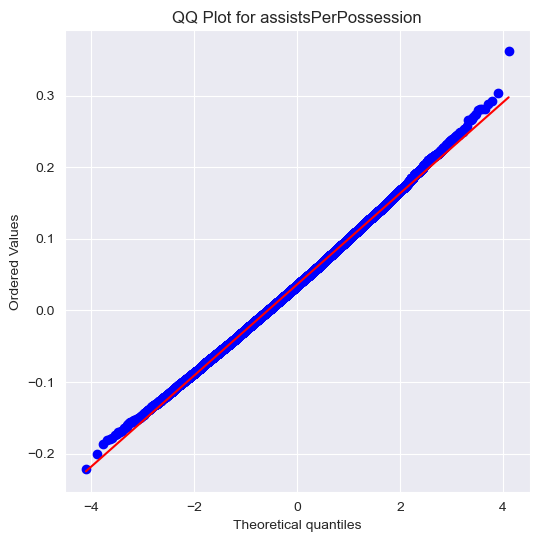

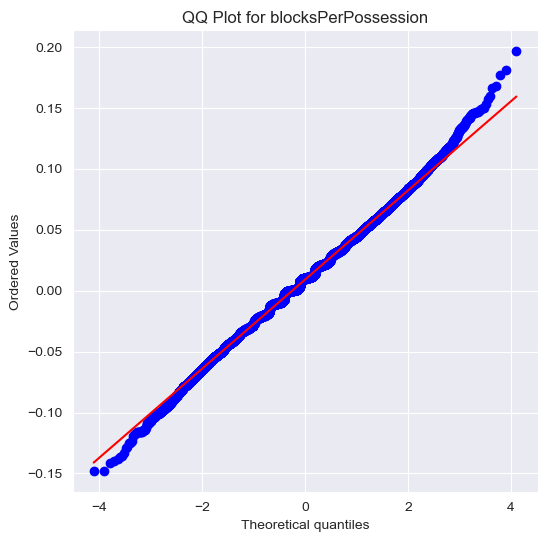

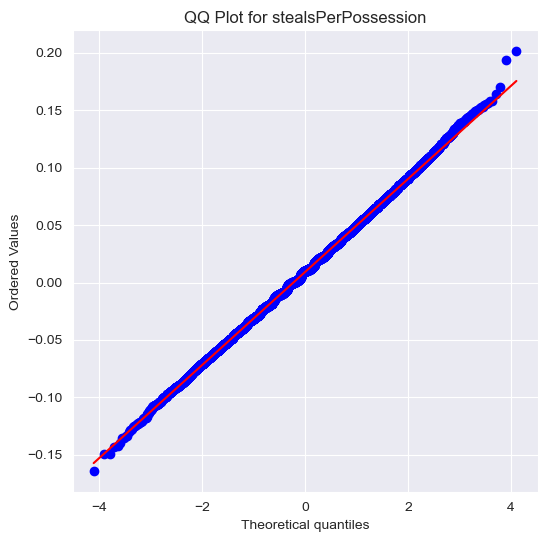

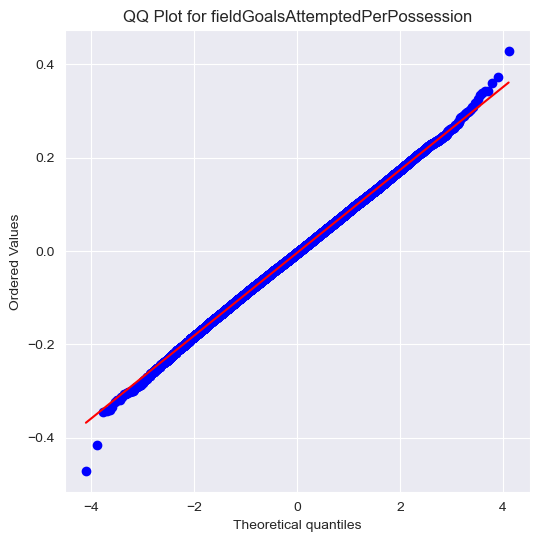

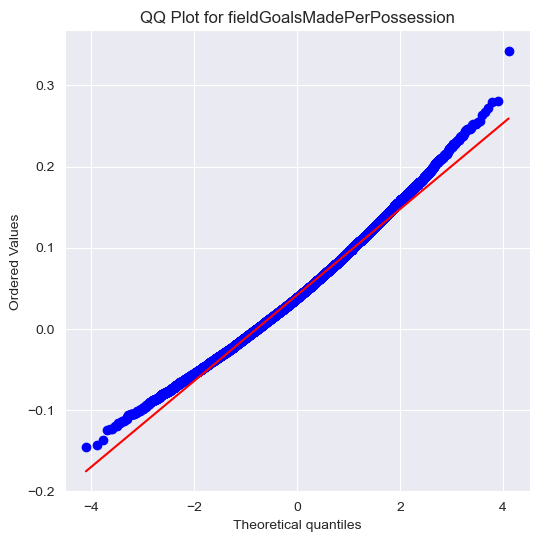

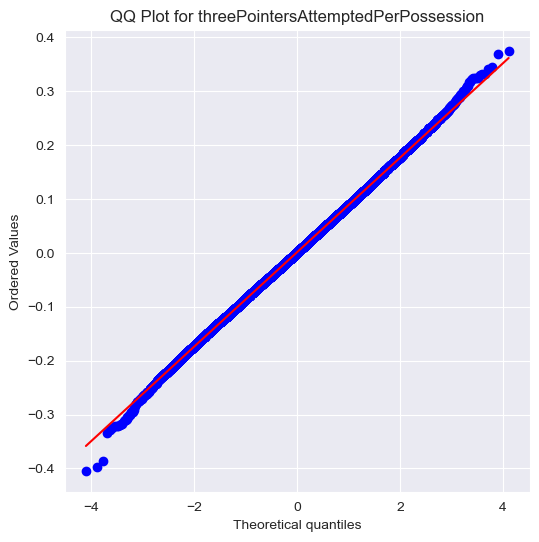

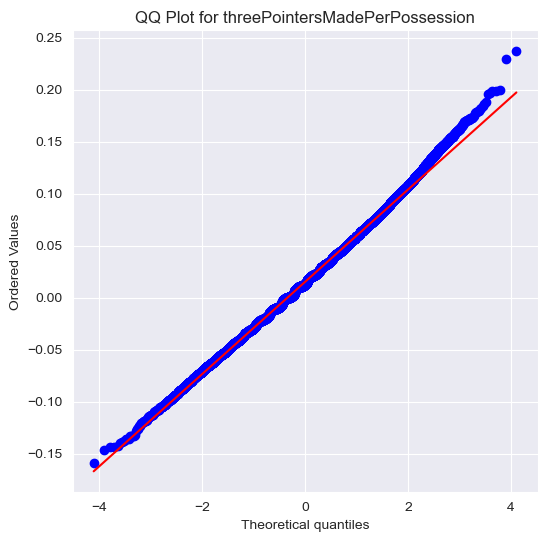

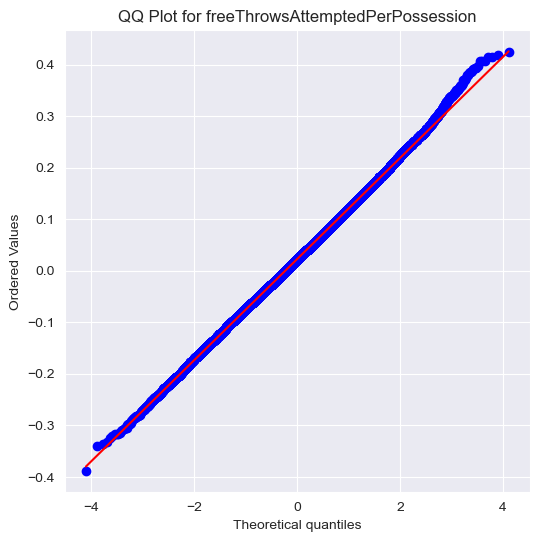

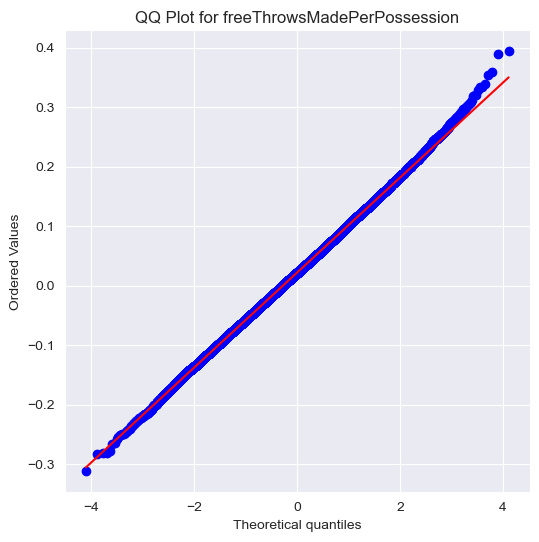

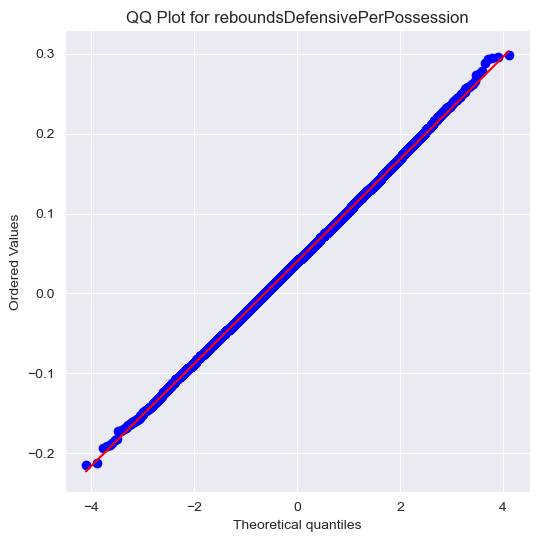

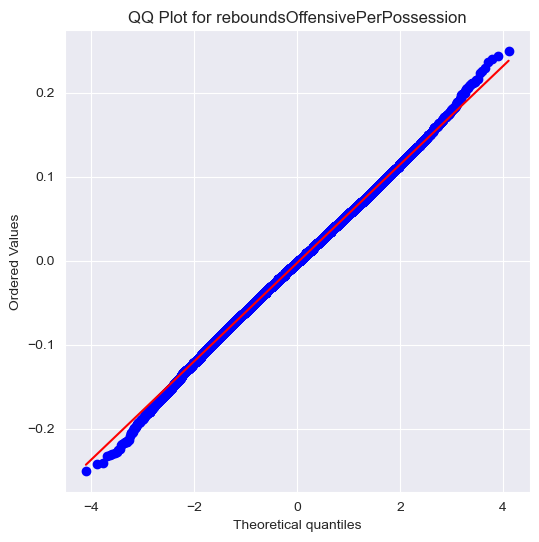

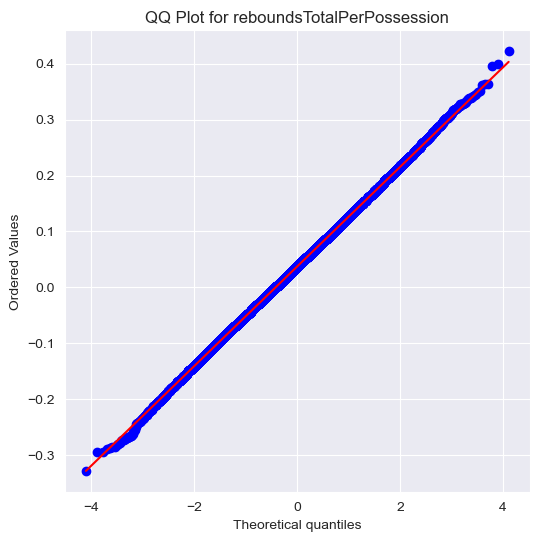

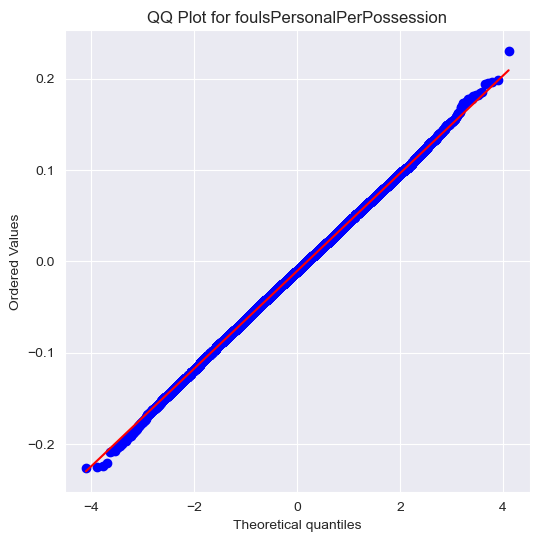

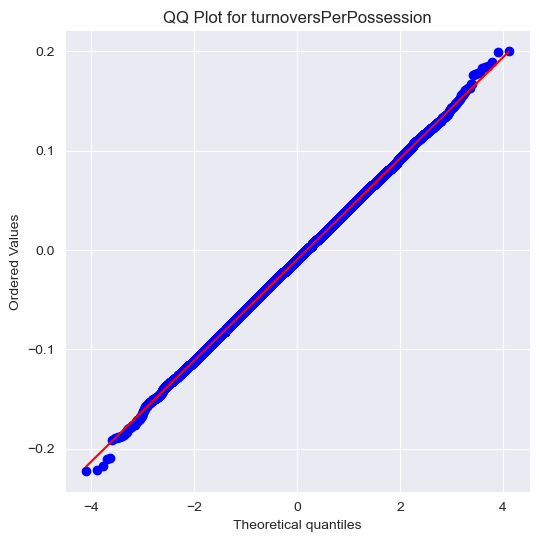

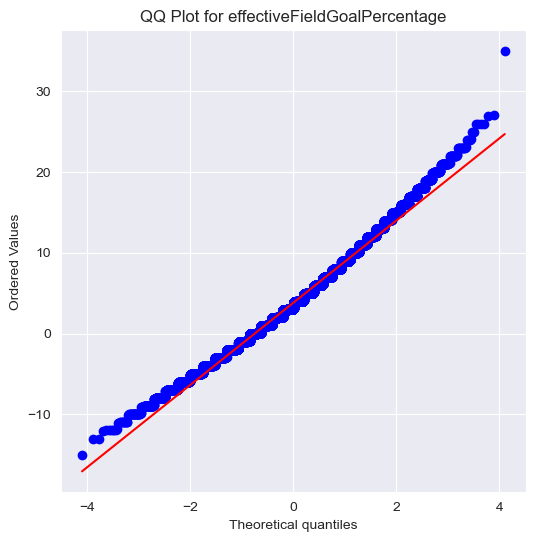

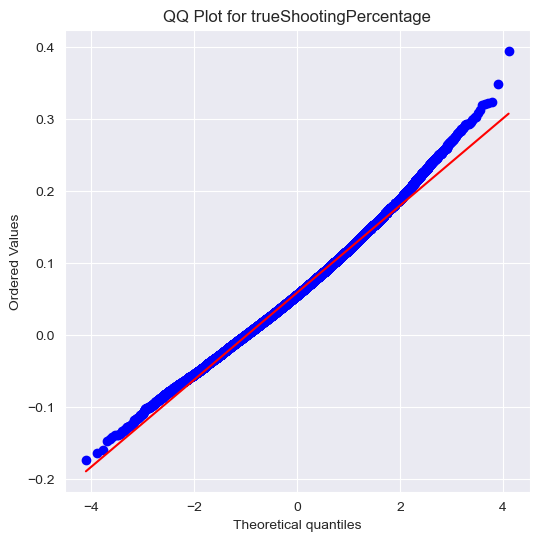

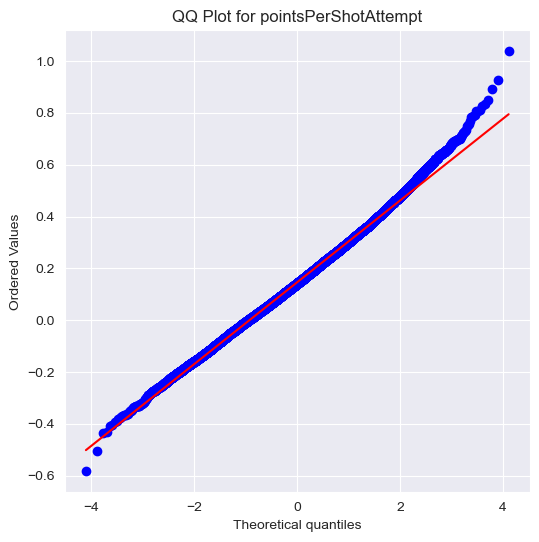

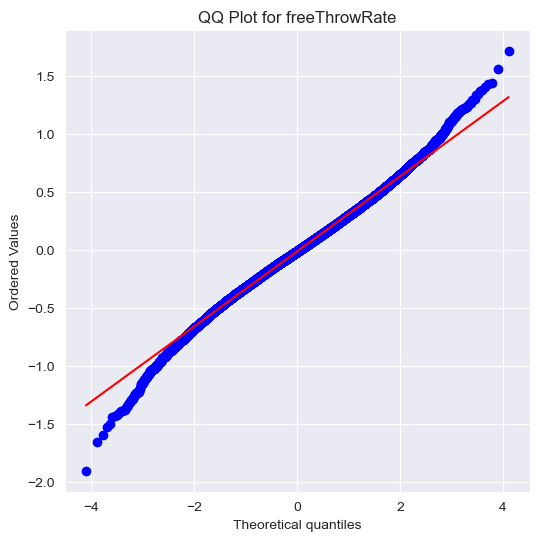

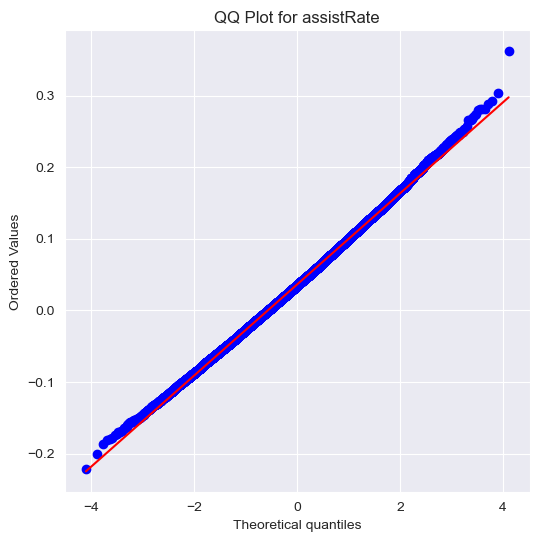

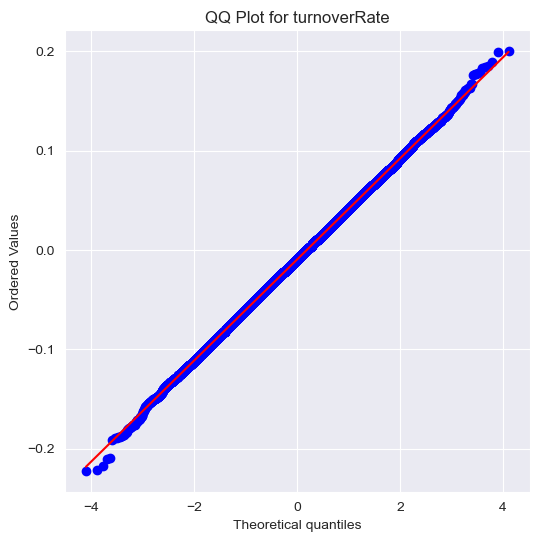

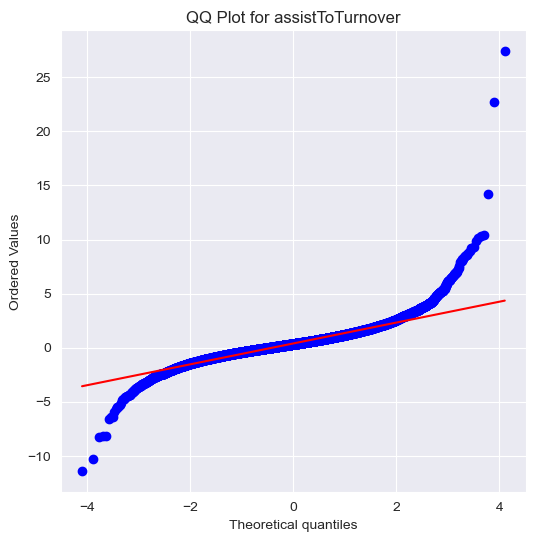

In [13]:
# Plot QQ Plots
for col in differences.columns:
    plt.figure(figsize=(6, 6))
    stats.probplot(differences[col], dist="norm", plot=plt)
    plt.title(f"QQ Plot for {col}")
    plt.show()

All distributions do follow a Normal Distributions when inspecting the QQ-Plots apart from teamScorePerPossessions and assistToTurnover. The only outlier is the threePointersPercentage, whose QQ-Plot suggests that the distribution has heavy tails. This can be attributed to the fact that three pointers weren't commonly thrown in earlier years (90s) and therefore there were a lot of games where no threes were taken or 0/1 or 1/1 threes were made, leading to the heavy tails.

In [14]:
# Print rows where threePointersPercentage == 1.0
team_statistics_df[team_statistics_df["threePointersPercentage"] == 1.0]

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,opponentTeamId,opponentTeamCity,opponentTeamName,opponentTeamTricode,...,reboundsTotalPerPossession,foulsPersonalPerPossession,turnoversPerPossession,effectiveFieldGoalPercentage,trueShootingPercentage,pointsPerShotAttempt,freeThrowRate,assistRate,turnoverRate,assistToTurnover
2029,29600176,1610612749,Milwaukee,Bucks,MIL,bucks,1610612753,Orlando,Magic,ORL,...,0.558534,0.256926,0.145219,38.006494,0.546329,1.298701,0.868421,0.212243,0.145219,1.461538
3876,29700443,1610612754,Indiana,Pacers,IND,pacers,1610612761,Toronto,Raptors,TOR,...,0.415896,0.265712,0.161738,37.021127,0.545611,1.253521,0.648649,0.277264,0.161738,1.714286
4703,29700027,1610612765,Detroit,Pistons,DET,pistons,1610612752,New York,Knicks,NYK,...,0.326188,0.244641,0.104846,31.021429,0.547530,1.342857,1.161290,0.163094,0.104846,1.555556
5605,29800303,1610612762,Utah,Jazz,UTA,jazz,1610612750,Minnesota,Timberwolves,MIN,...,0.498449,0.199380,0.210456,30.044118,0.533935,1.323529,1.233333,0.243686,0.210456,1.157895
7031,29900773,1610612759,San Antonio,Spurs,SAS,spurs,1610612766,Charlotte,Hornets,CHH,...,0.490654,0.210280,0.128505,29.013333,0.441176,0.960000,0.517241,0.233645,0.128505,1.818182
7051,29900771,1610612737,Atlanta,Hawks,ATL,hawks,1610612758,Sacramento,Kings,SAC,...,0.503018,0.150905,0.090543,45.009615,0.461255,0.961538,0.222222,0.231388,0.090543,2.555556
7303,29900640,1610612737,Atlanta,Hawks,ATL,hawks,1610612751,New Jersey,Nets,NJN,...,0.504484,0.224215,0.100897,36.012658,0.526030,1.227848,0.833333,0.280269,0.100897,2.777778
9902,20000524,1610612737,Atlanta,Hawks,ATL,hawks,1610612746,Los Angeles,Clippers,LAC,...,0.414717,0.255211,0.116972,46.017045,0.568182,1.227273,0.347826,0.308379,0.116972,2.636364
11101,20101117,1610612755,Philadelphia,76ers,PHI,sixers,1610612749,Milwaukee,Bucks,MIL,...,0.444925,0.288600,0.096200,33.013889,0.515926,1.277778,1.181818,0.240500,0.096200,2.500000
11116,20101111,1610612760,Seattle,SuperSonics,SEA,supersonics,1610612746,Los Angeles,Clippers,LAC,...,0.334410,0.288284,0.161439,45.012987,0.616538,1.324675,0.288889,0.357472,0.161439,2.214286


In [15]:
# Perform ttest of differences
from statsmodels.stats.multitest import multipletests
import pingouin as pg

results = []
for col in cols:
    diffs = differences[col]

    if col == "teamScorePerPossession" or col == "assistToTurnover":
        res = pg.wilcoxon(diffs)
        statistic = res['W-val'].iloc[0]
        p_value = res['p-val'].iloc[0]
        effect_size = res['RBC'].iloc[0]
    else:
        statistic, p_value = stats.ttest_1samp(diffs, 0)
        effect_size = diffs.mean() / diffs.std(ddof=1)
    results.append({
        'col': col,
        'mean_diff': diffs.mean(),
        'std_diff': diffs.std(ddof=1),
        't_statistic': statistic,
        'p_value': p_value,
        'effect_size': effect_size
    })

results_df = pd.DataFrame(results)

# Bonferri Correction
results_df['corrected_p_value'] = multipletests(results_df['p_value'], method='bonferroni')[1]
results_df = results_df.sort_values('effect_size', ascending=False).reset_index(drop=True)
results_df

,col,mean_diff,std_diff,t_statistic,p_value,effect_size,corrected_p_value
0,teamScorePerPossession,0.121791,0.088686,2.931329e+06,0.000000e+00,0.990043,0.000000e+00
1,trueShootingPercentage,0.059002,0.060643,1.802329e+02,0.000000e+00,0.972939,0.000000e+00
2,pointsPerShotAttempt,0.146754,0.158042,1.720150e+02,0.000000e+00,0.928577,0.000000e+00
3,fieldGoalsPercentage,0.050512,0.060680,1.542061e+02,0.000000e+00,0.832441,0.000000e+00
4,fieldGoalsMadePerPossession,0.042019,0.053070,1.466706e+02,0.000000e+00,0.791762,0.000000e+00
5,effectiveFieldGoalPercentage,3.833261,5.106214,1.390650e+02,0.000000e+00,0.750705,0.000000e+00
6,reboundsDefensivePerPossession,0.040144,0.064072,1.160644e+02,0.000000e+00,0.626543,0.000000e+00
7,assistRate,0.036557,0.063669,1.063617e+02,0.000000e+00,0.574165,0.000000e+00
8,assistsPerPossession,0.036557,0.063669,1.063617e+02,0.000000e+00,0.574165,0.000000e+00
9,assistToTurnover,0.399699,1.010849,1.507344e+08,0.000000e+00,0.479485,0.000000e+00


We have also performed bonferri correction to adjust for the fact we have been running multiple tests, but they are all highly significant results. We have also used Cohen's d metric to identify the effect size, where a value of 0.2 represents a small, 0.5 a medium and 0.8 a large effect. The exception is the teamScore, where because of non-normality we have performed a wilcoxon test with Biserial-Rank effect size, where 0.1 is small, 0.3 is medium and 0.5 is large.
From the table we can identify that the largest differences between winning and losing teams are the team score unsurprisingly. Another interesting note is that defensive rebounds are quite a bit more important than assists, indicating that perhaps teamplay isn't quite as important. Another interesting fact is that turnoversPerPossession does not have a high effect size (-0.18), indicating that even if a team commits a lot of turnovers isn't quite as punishing.

# Collinearity

In [16]:
# Drop non-boxscore columns
box_score = team_statistics_df.drop(columns=["gameId", "gameDate", "teamCity", "teamName", "teamId", "opponentTeamName", "opponentTeamCity", "opponentTeamId", "opponentTeamName"])
# Drop all normal boxscore columns in favor for PerPossession stats
box_score = box_score.filter(regex=r'(PerPossession|Percentage)$')

corr = box_score.corr().abs()
high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .loc[lambda s: s > 0.75]
        .sort_values(ascending=False)
)
print(high_corr)

freeThrowsAttemptedPerPossession     freeThrowsMadePerPossession       0.924918
fieldGoalsPercentage                 trueShootingPercentage            0.907275
fieldGoalsMadePerPossession          effectiveFieldGoalPercentage      0.874434
teamScorePerPossession               trueShootingPercentage            0.870364
threePointersAttemptedPerPossession  threePointersMadePerPossession    0.842157
fieldGoalsPercentage                 fieldGoalsMadePerPossession       0.824900
teamScorePerPossession               fieldGoalsMadePerPossession       0.817500
fieldGoalsPercentage                 teamScorePerPossession            0.789788
reboundsDefensivePerPossession       reboundsTotalPerPossession        0.761368
dtype: float64


In [17]:
box_score = box_score.drop(columns=["freeThrowsMadePerPossession", "fieldGoalsPercentage", "fieldGoalsMadePerPossession", "teamScorePerPossession", "threePointersMadePerPossession", "reboundsTotalPerPossession"])

We decided to drop all the "MadePerPossession" columns because that metric essentially is explained already via Attempts/Possesion and Percentage, since thats the product of "MadePerPossession". We also decided to drop "ReboundsTotalPerPossession", because we have that metric via defensive and offensive rebounds. FieldGoalPercentage gets dropped because effectiveFieldGoalPercentage is an advanced version of it.

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calculate_vif(df):
    """Return a DataFrame with features and their VIFs."""
    X = df.copy()
    X['Intercept'] = 1.0
    vif_data = []
    for i, feature in enumerate(X.columns):
        if feature == 'Intercept':
            continue
        vif = variance_inflation_factor(X.values, i)
        vif_data.append({'feature': feature, 'VIF': vif})
    return pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

def drop_high_vif(df, thresh=5.0):
    """
    Iteratively drop the variable with the highest VIF above threshold.

    Parameters
    ----------
    df : pd.DataFrame
        Numeric predictors only (no target variable).
    thresh : float
        VIF threshold; drop features until all VIFs <= thresh.

    Returns
    -------
    pd.DataFrame
        Subset of df with VIFs all below thresh.
    """
    df_current = df.copy()
    while True:
        vif_df = calculate_vif(df_current)
        max_vif = vif_df['VIF'].max()
        if max_vif <= thresh:
            break
        # identify and drop the worst
        worst_feature = vif_df.iloc[0]['feature']
        print(f"Dropping '{worst_feature}' with VIF={max_vif:.2f}")
        df_current = df_current.drop(columns=[worst_feature])
    return df_current

In [19]:
reduced_box_score = drop_high_vif(box_score, thresh=15.0)
print(calculate_vif(reduced_box_score))
features = reduced_box_score.columns

C:\Users\trist\miniconda3\envs\Intro_Data_Science_Project\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping 'fieldGoalsAttemptedPerPossession' with VIF=inf
                                feature       VIF
12               trueShootingPercentage  7.786152
11         effectiveFieldGoalPercentage  4.773097
6      freeThrowsAttemptedPerPossession  2.510084
2                  assistsPerPossession  1.793980
8        reboundsOffensivePerPossession  1.775866
10               turnoversPerPossession  1.660366
0               threePointersPercentage  1.643005
5   threePointersAttemptedPerPossession  1.447980
1                  freeThrowsPercentage  1.279940
9            foulsPersonalPerPossession  1.185352
7        reboundsDefensivePerPossession  1.147753
4                   stealsPerPossession  1.093273
3                   blocksPerPossession  1.055586


We dropped "fieldGoalsAttemptedPerPossession" from performing VIF and always dropping the highest variable if its VIF is > 15

# Linear Regression

In [20]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X = team_statistics_df[features]
y = team_statistics_df["win"]
features = X.columns

logit = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV(cv=5, penalty='l1', solver='saga', scoring='roc_auc', max_iter=100000)
)
logit.fit(X, y)
coefs = logit.named_steps['logisticregressioncv'].coef_.ravel()
importance = pd.Series(abs(coefs), index=X.columns).sort_values(ascending=False)
print(importance)

trueShootingPercentage                 2.015271
reboundsDefensivePerPossession         1.670203
stealsPerPossession                    1.029272
reboundsOffensivePerPossession         0.743793
turnoversPerPossession                 0.638150
threePointersAttemptedPerPossession    0.540532
freeThrowsAttemptedPerPossession       0.309624
blocksPerPossession                    0.287246
assistsPerPossession                   0.250577
foulsPersonalPerPossession             0.200395
threePointersPercentage                0.150954
freeThrowsPercentage                   0.031659
effectiveFieldGoalPercentage           0.000000
dtype: float64


# Tree Based Model

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
rf = RandomForestClassifier(n_estimators=200).fit(X_train, y_train)
perm = permutation_importance(rf, X_test, y_test, n_repeats=30, scoring='roc_auc')
importance = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
print(importance)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


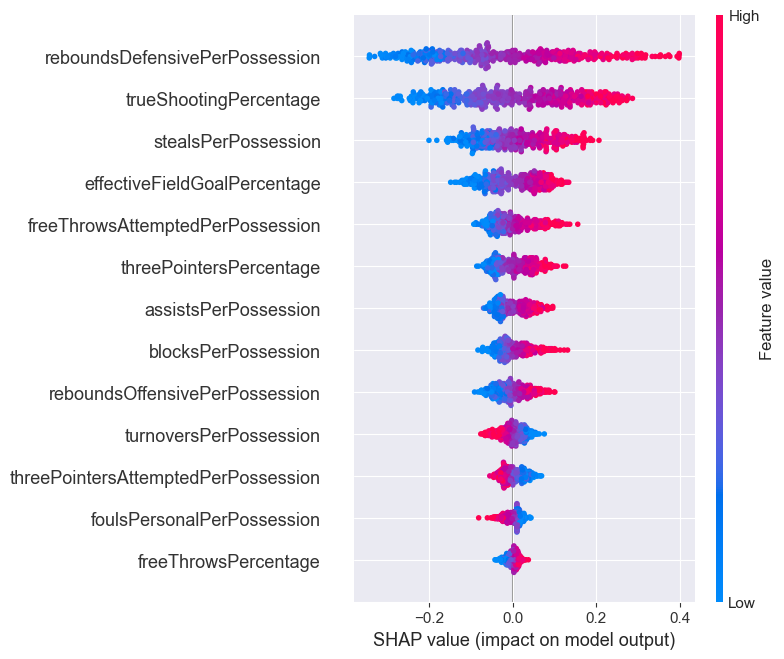

In [46]:
import shap
explainer = shap.TreeExplainer(rf)
# only explain 500 examples instead of, say, 10,000
X_small = X_test.sample(n=500, random_state=42)
shap_vals = explainer.shap_values(X_small)
shap.summary_plot(shap_vals[1], X_small)   # class=1 = win

# LDA

LDA coefficients (sorted by magnitude):
stealsPerPossession                    33.836955
trueShootingPercentage                 32.218670
reboundsDefensivePerPossession         30.864618
reboundsOffensivePerPossession         17.679251
turnoversPerPossession                 16.597346
blocksPerPossession                    10.861837
threePointersAttemptedPerPossession     5.962938
foulsPersonalPerPossession              5.404235
assistsPerPossession                    4.717737
freeThrowsAttemptedPerPossession        4.107861
threePointersPercentage                 1.275947
freeThrowsPercentage                    0.463967
effectiveFieldGoalPercentage            0.015435
dtype: float64


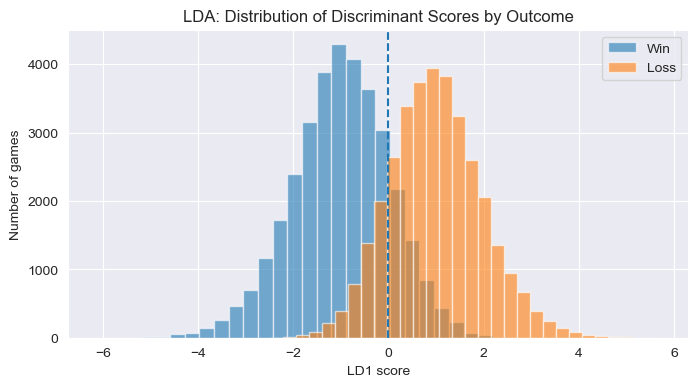

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X, y)
coef = pd.Series(lda.coef_[0], index=features)
print("LDA coefficients (sorted by magnitude):")
print(coef.abs().sort_values(ascending=False))

plt.figure(figsize=(8,4))
plt.hist(X_lda[y==1], bins=30, alpha=0.6, label="Win")
plt.hist(X_lda[y==0], bins=30, alpha=0.6, label="Loss")
plt.axvline(0, linestyle="--")             # cutoff at score=0
plt.legend()
plt.title("LDA: Distribution of Discriminant Scores by Outcome")
plt.xlabel("LD1 score")
plt.ylabel("Number of games")
plt.show()

# Conclusions over all models


After rescaling and averaging each feature over all models, it seems that TrueShootingPercentage, StealsPerPossession and reboundsDefensivePerPossession are the most important metrics on average. TrueShootingPercentage makes sense since it combines all scoring into one (2P, 3P and FT), StealsPerPossession and reboundsDefensivePerPossession explain the defense of the team, since steals lead to turnovers and less possessions for the opposing teams to score, and defensive rebounds can be thought of that your team will have more if the opposing team shoots poorly. Interestingly, assists do not quite matter as much.



In [22]:
from sklearn.preprocessing import MinMaxScaler


logit_feat = pd.Series(np.abs(coefs), index=features, name='logit_coef')
rf_feat = pd.Series(perm.importances_mean, index=features, name='rf_perm')
shap_feat = pd.Series(np.abs(shap_vals[1]).mean(axis=0), index=features, name='shap_meanabs')
lda_feat = pd.Series(np.abs(lda.coef_[0]), index=features, name='lda_coef')

feature_importance = pd.concat([logit_feat, rf_feat, shap_feat, lda_feat], axis=1)

scaler = MinMaxScaler()
feature_importance[:] = scaler.fit_transform(feature_importance)
feature_importance['avg'] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values('avg', ascending=False)
print(feature_importance)

NameError: name 'perm' is not defined

In [23]:
# Save features into csv
features = features.tolist()
cols = ["gameId", "gameDate", "teamCity", "teamName", "opponentTeamCity", "opponentTeamName", "home", "win", "teamScore", "opponentScore"] + features
important_features_df = team_statistics_df[cols]
important_features_df.to_csv(os.path.join(DATA_PATH, "important_features.csv"), index=False)